In [1]:
!pip install fastMONAI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━

In [2]:
from google.colab import drive
from pathlib import Path
import tarfile
import os
import shutil
import tempfile
import pandas as pd
import json
import glob
import torch
from sklearn.model_selection import train_test_split

from fastMONAI.vision_all import *
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [3]:
torch.cuda.empty_cache()

# Getting the data

In [4]:
# Mounting to Google drive
drive.mount('/content/gdrive')
# Making a path to the folder with all the datasets
path = Path('/content/gdrive/MyDrive/Dataset/MSD')

Mounted at /content/gdrive


Checking subdirectories

In [5]:
# List all files and directories at the given path
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))  # print the full path of each file
    for name in dirs:
        print(os.path.join(root, name))  # print the full path of each directory

/content/gdrive/MyDrive/Dataset/MSD/license.txt
/content/gdrive/MyDrive/Dataset/MSD/Task02_Heart.tar
/content/gdrive/MyDrive/Dataset/MSD/Task05_Prostate.tar
/content/gdrive/MyDrive/Dataset/MSD/Task06_Lung.tar
/content/gdrive/MyDrive/Dataset/MSD/Task04_Hippocampus.tar
/content/gdrive/MyDrive/Dataset/MSD/Task09_Spleen.tar
/content/gdrive/MyDrive/Dataset/MSD/Task10_Colon.tar
/content/gdrive/MyDrive/Dataset/MSD/Task01_BrainTumour.tar
/content/gdrive/MyDrive/Dataset/MSD/Task03_Liver.tar
/content/gdrive/MyDrive/Dataset/MSD/Task07_Pancreas.tar
/content/gdrive/MyDrive/Dataset/MSD/Task08_HepaticVessel.tar


# Chose one dataset and make a directory

In [7]:
path_braintumour = path/'Task01_BrainTumour.tar'

In [8]:

# Create a temporary directory to extract the archive to
braintumour_dir = tempfile.mkdtemp()

# Open the tar-file for reading
with tarfile.open(path_braintumour, 'r') as tar:
    # Extract all contents of the archive to the temporary directory
    tar.extractall(braintumour_dir)

# Checking what the extracted directory contains
print(os.listdir(braintumour_dir))

['Task01_BrainTumour']


In [9]:
# Moving into the folder and checking again
braintumour_dir = os.path.join(braintumour_dir, 'Task01_BrainTumour')
print(os.listdir(braintumour_dir))

['labelsTr', 'dataset.json', 'imagesTr', '._labelsTr', '._imagesTs', '._dataset.json', 'imagesTs', '._imagesTr']


# Make dataframe

In [10]:
dataset = os.path.join(braintumour_dir, "dataset.json")

# load the JSON data
with open(dataset) as f:
    data = json.load(f)

# convert the JSON data to a Pandas DataFrame
df = pd.json_normalize(data)

# display the DataFrame
df.head()

,name,description,reference,licence,release,tensorImageSize,numTraining,numTest,training,test,modality.0,modality.1,modality.2,modality.3,labels.0,labels.1,labels.2,labels.3
0,BRATS,Gliomas segmentation tumour and oedema in on brain images,https://www.med.upenn.edu/sbia/brats2017.html,CC-BY-SA 4.0,2.0 04/05/2018,4D,484,266,"[{'image': './imagesTr/BRATS_457.nii.gz', 'label': './labelsTr/BRATS_457.nii.gz'}, {'image': './imagesTr/BRATS_306.nii.gz', 'label': './labelsTr/BRATS_306.nii.gz'}, {'image': './imagesTr/BRATS_206.nii.gz', 'label': './labelsTr/BRATS_206.nii.gz'}, {'image': './imagesTr/BRATS_449.nii.gz', 'label': './labelsTr/BRATS_449.nii.gz'}, {'image': './imagesTr/BRATS_318.nii.gz', 'label': './labelsTr/BRATS_318.nii.gz'}, {'image': './imagesTr/BRATS_218.nii.gz', 'label': './labelsTr/BRATS_218.nii.gz'}, {'image': './imagesTr/BRATS_434.nii.gz', 'label': './labelsTr/BRATS_434.nii.gz'}, {'image': './imagesTr...","[./imagesTs/BRATS_557.nii.gz, ./imagesTs/BRATS_549.nii.gz, ./imagesTs/BRATS_683.nii.gz, ./imagesTs/BRATS_534.nii.gz, ./imagesTs/BRATS_545.nii.gz, ./imagesTs/BRATS_538.nii.gz, ./imagesTs/BRATS_526.nii.gz, ./imagesTs/BRATS_691.nii.gz, ./imagesTs/BRATS_573.nii.gz, ./imagesTs/BRATS_510.nii.gz, ./imagesTs/BRATS_561.nii.gz, ./imagesTs/BRATS_502.nii.gz, ./imagesTs/BRATS_662.nii.gz, ./imagesTs/BRATS_601.nii.gz, ./imagesTs/BRATS_701.nii.gz, ./imagesTs/BRATS_670.nii.gz, ./imagesTs/BRATS_713.nii.gz, ./imagesTs/BRATS_613.nii.gz, ./imagesTs/BRATS_746.nii.gz, ./imagesTs/BRATS_646.nii.gz, ./imagesTs/BRAT...",FLAIR,T1w,t1gd,T2w,background,edema,non-enhancing tumor,enhancing tumour


In [11]:
# Extracting a new dataframe with the trainingdata
training_data = df['training'][0]
train_df = pd.DataFrame(training_data)

train_df.head()

,image,label
0,./imagesTr/BRATS_457.nii.gz,./labelsTr/BRATS_457.nii.gz
1,./imagesTr/BRATS_306.nii.gz,./labelsTr/BRATS_306.nii.gz
2,./imagesTr/BRATS_206.nii.gz,./labelsTr/BRATS_206.nii.gz
3,./imagesTr/BRATS_449.nii.gz,./labelsTr/BRATS_449.nii.gz
4,./imagesTr/BRATS_318.nii.gz,./labelsTr/BRATS_318.nii.gz


In [12]:
# Fixing the paths in the df
for index in range(0,len(train_df)):

  # Removing ./ so that it can be joined to another path
  train_df["image"][index] = train_df["image"][index].replace("./","")
  # Joinging image path to the dir path
  train_df["image"][index] = os.path.join(braintumour_dir, train_df["image"][index])

  # Removing ./ so that it can be joined to another path
  train_df["label"][index] = train_df["label"][index].replace("./","")
  # Joinging label path to the dir path
  train_df["label"][index] = os.path.join(braintumour_dir, train_df["label"][index])

train_df.head()

,image,label
0,/tmp/tmp3t1o26cq/Task01_BrainTumour/imagesTr/BRATS_457.nii.gz,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_457.nii.gz
1,/tmp/tmp3t1o26cq/Task01_BrainTumour/imagesTr/BRATS_306.nii.gz,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_306.nii.gz
2,/tmp/tmp3t1o26cq/Task01_BrainTumour/imagesTr/BRATS_206.nii.gz,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_206.nii.gz
3,/tmp/tmp3t1o26cq/Task01_BrainTumour/imagesTr/BRATS_449.nii.gz,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_449.nii.gz
4,/tmp/tmp3t1o26cq/Task01_BrainTumour/imagesTr/BRATS_318.nii.gz,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_318.nii.gz


In [13]:
train_df.shape

(484, 2)

In [14]:
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((435, 2), (49, 2))

# Access data

In [15]:
# img_list is a list of img paths, dtype describes the datatype i want to convert the images to
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=12)

In [16]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1,voxel_count_2,voxel_count_3
0,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_033.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8813985,35716,28165,50134.0
1,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_393.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8784241,103826,4212,35721.0
2,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_478.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8850722,55793,7328,14157.0
3,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_349.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8809606,103227,6590,8577.0
4,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_481.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8870832,37895,4159,15114.0


In [17]:
data_info_df = med_dataset.summary()

In [18]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,240,240,155,1.0,1.0,1.0,RAS+,/tmp/tmp3t1o26cq/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz,435


In [19]:
# Voxel value that appears most often in dim_0, dim_1 and dim_2, and wheter the data should be reoriented.
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In [20]:
bs=5

In [21]:
# Gives the largest image in pxels after resampling and reordering
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[240.0, 240.0, 155.0]

In [36]:
size = [160,160,128]

In [37]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5)]  # RandomMotion()

In [38]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(valid_pct=0.1, seed=42), # By passing valid_pct=0.1, we tell it to get a random 10% of the training set for validation.
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [39]:
dls = dblock.dataloaders(train_df, bs=bs)

In [40]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(392, 43)

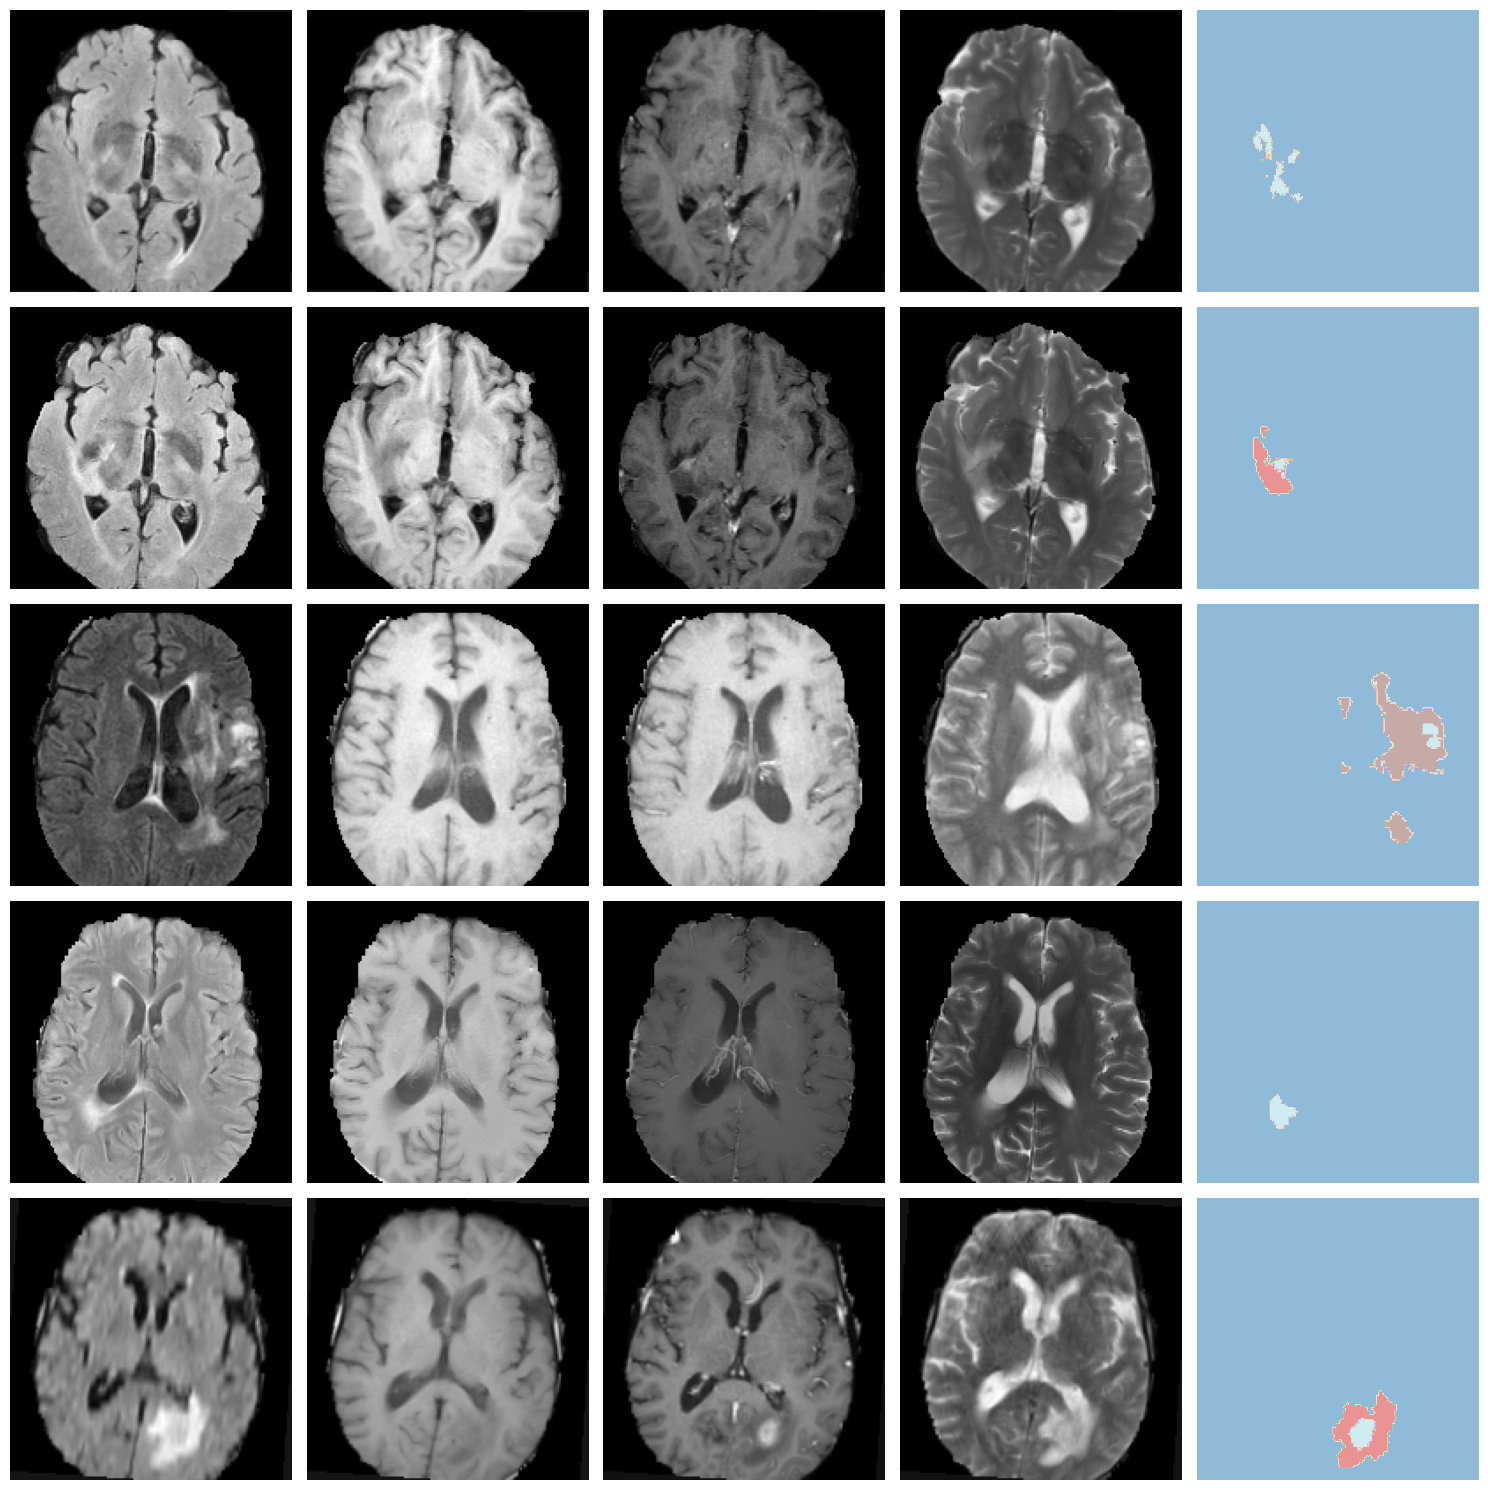

In [41]:
dls.show_batch(anatomical_plane=2) 

# Train UNet model

In [46]:
model = UNet(
    spatial_dims=3, 
    in_channels=4, 
    out_channels=1, 
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2), 
    num_res_units=2
)
model = model.model

In [47]:
loss_func = CustomLoss(loss_func=DiceLoss(sigmoid=True))

In [48]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=binary_dice_score)

SuggestedLRs(valley=0.010964781977236271)

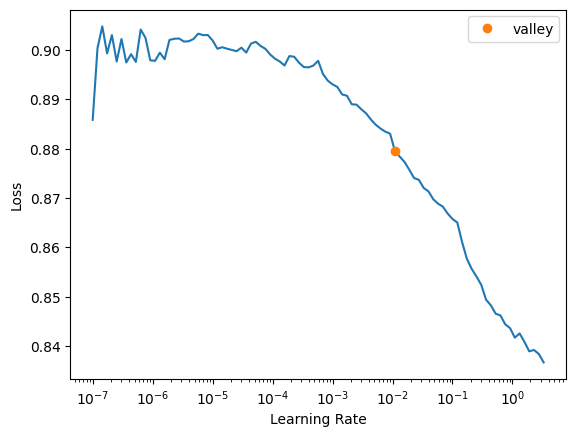

In [49]:
learn.lr_find()

In [51]:
lr = 0.010964781977236271

In [52]:
learn.fit_flat_cos(4 ,lr)

epoch,train_loss,valid_loss,binary_dice_score,time
0,0.810460,0.783462,0.594015,11:10
1,0.662597,0.591566,0.467151,11:19
2,0.389033,0.210977,0.837993,11:04
3,0.166870,0.118851,0.915852,11:13


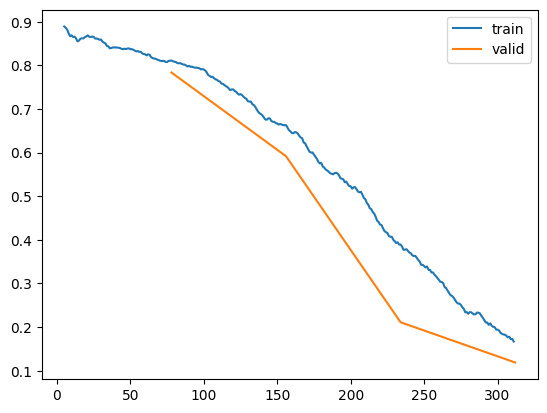

In [53]:
learn.recorder.plot_loss()

In [54]:
learn.save('brain-model')

Path('models/brain-model.pth')

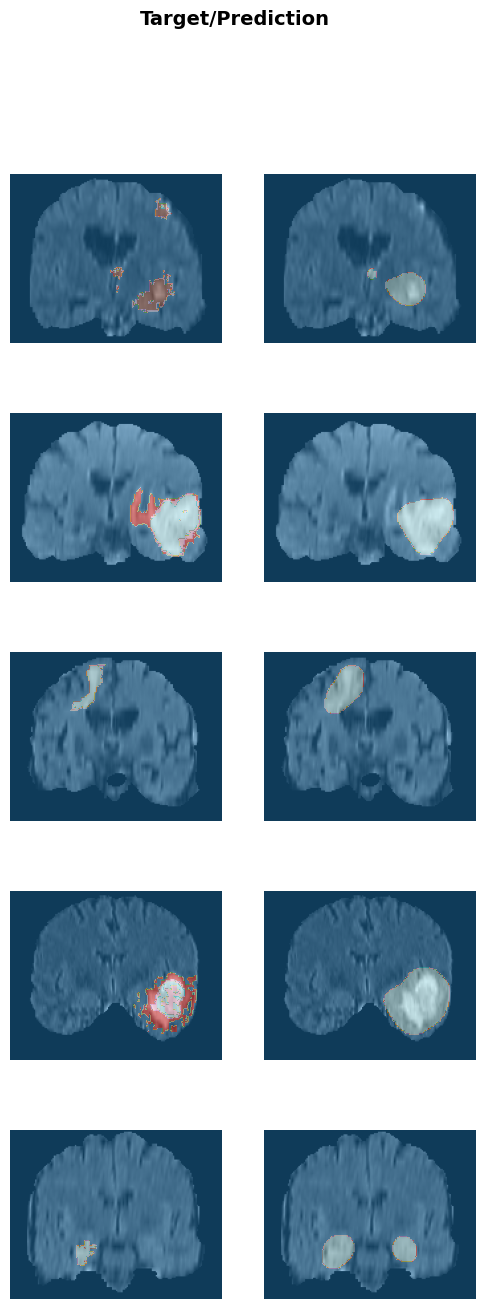

In [55]:
learn.show_results(anatomical_plane=1)

# Test model

In [56]:
learn.load('brain-model');

In [57]:
test_dl = learn.dls.test_dl(test_df,with_labels=True)

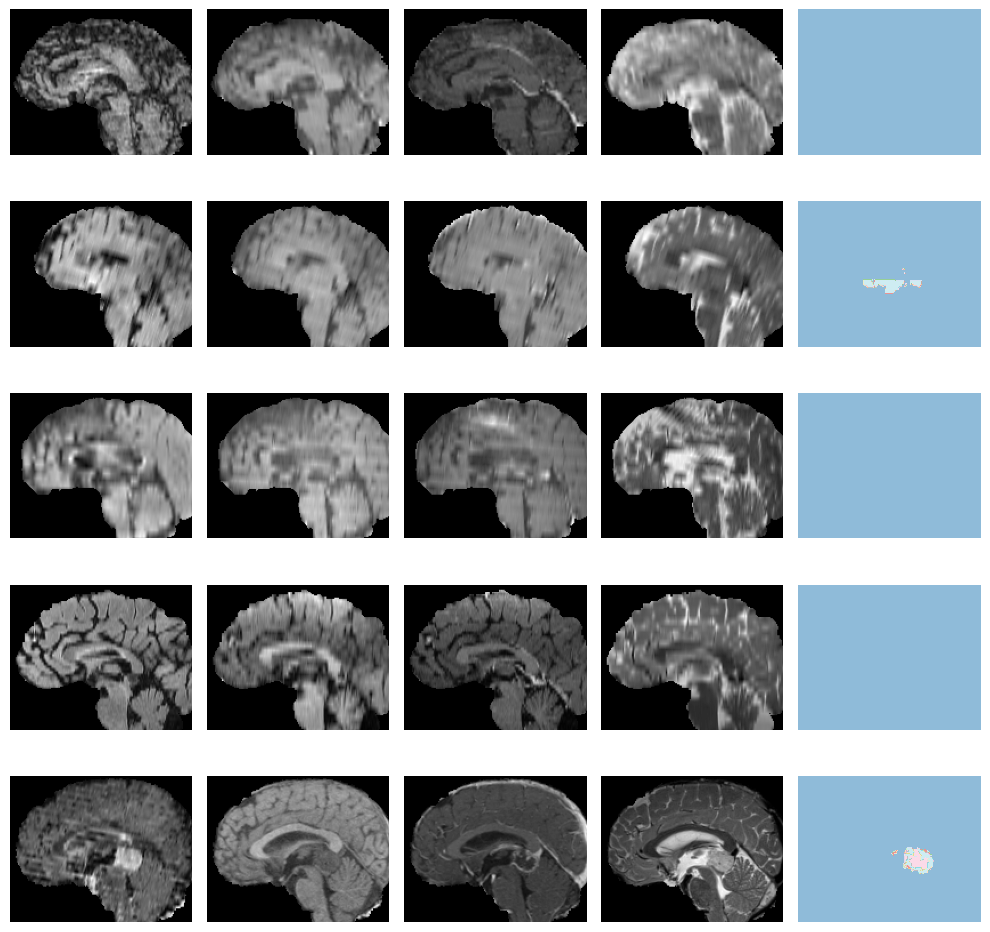

In [58]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

In [59]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([49, 1, 160, 160, 128]), torch.Size([49, 1, 160, 160, 128]))

In [60]:
binary_dice_score(pred_acts, labels)

tensor(0.9742)

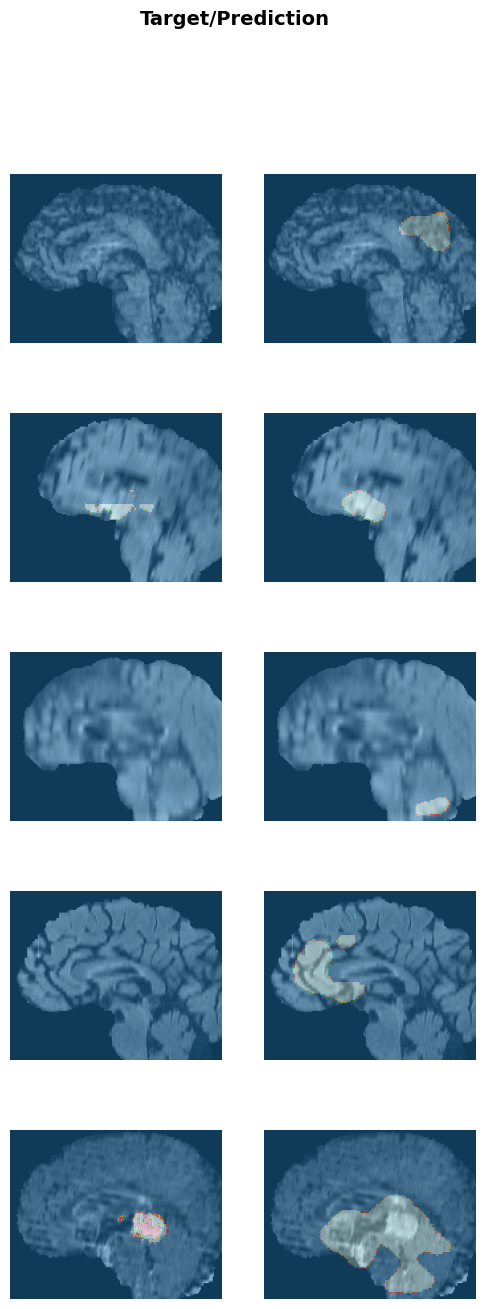

In [61]:
learn.show_results(anatomical_plane=0, dl=test_dl)

# Export learner

In [62]:
store_variables(pkl_fn='vars.pkl', size=size, reorder=reorder,  resample=resample)

In [64]:
learn.export('brain_model.pkl')

In [65]:
# When you're done, you can delete the temporary directory and its contents
shutil.rmtree(braintumour_dir)